# Multi-Class Prediction of Obesity Risk
Run after following notebooks are run:
1. **01 Data Cleaning**
2. **02 EDA**

## Development Notes


In [92]:
## set up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

## Load Data

In [2]:
train = pd.read_pickle('train_clean.pkl')
test = pd.read_pickle('test_clean.pkl')

## separate in to features and response variable
x_train = train.drop('NObeyesdad', axis=1)
y_train = train['NObeyesdad']

x_test = test

## One Hot Encoding / Label Encoding

In [3]:
## take note of 'CALC' - train has 3 levels, but test has 4
print('train: ', x_train.CALC.unique())
print('test: ', x_test.CALC.unique())

CALC_levels = x_test.CALC.cat.categories.tolist()

train:  ['Sometimes', 'no', 'Frequently']
Categories (4, object): ['no' < 'Sometimes' < 'Frequently' < 'Always']
test:  ['Sometimes', 'no', 'Frequently', 'Always']
Categories (4, object): ['no' < 'Sometimes' < 'Frequently' < 'Always']


In [87]:
## list categorical columns, excluding CALC, that can be assigned automatically
cols_onehot_auto = x_train.columns[x_train.dtypes=='category'].drop('CALC')

## use ColumnTransformer so only categorical columns are affected
ct = ColumnTransformer([('One_Hot_Cat', OneHotEncoder(drop='first'), cols_onehot_auto),
                        ('One_Hot_Cat_Manual', OneHotEncoder(drop='first', categories=[CALC_levels]), ['CALC'])],
                       remainder='passthrough', verbose_feature_names_out=False)
x_train_onehot = pd.DataFrame(ct.fit_transform(x_train), columns=ct.get_feature_names_out())
x_test_onehot = pd.DataFrame(ct.transform(x_test), columns=ct.get_feature_names_out())

x_train_onehot.columns.tolist()

['Gender_Male',
 'family_history_with_overweight_yes',
 'FAVC_yes',
 'CAEC_Frequently',
 'CAEC_Sometimes',
 'CAEC_no',
 'SMOKE_yes',
 'SCC_yes',
 'MTRANS_Bike',
 'MTRANS_Motorbike',
 'MTRANS_Public_Transportation',
 'MTRANS_Walking',
 'CALC_Sometimes',
 'CALC_Frequently',
 'CALC_Always',
 'Age',
 'Height',
 'Weight',
 'FCVC',
 'NCP',
 'CH2O',
 'FAF',
 'TUE',
 'BMI']

In [86]:
## ALTERNATE TRANSFORMATION - MAINLY USED FOR KNN
## list categorical columns, excluding ordinal categories, that can be assigned automatically
cols_onehot_auto = x_train.columns[x_train.dtypes=='category'].drop(['CALC', 'CAEC'])

## use ColumnTransformer so only categorical columns are affected
ct_ord = ColumnTransformer([('One_Hot_Cat', OneHotEncoder(drop='first'), cols_onehot_auto),
                            ('Ord_Cat_CAEC', OrdinalEncoder(), ['CAEC']),
                            ('Ord_Cat_CALC', OrdinalEncoder(categories=[CALC_levels]), ['CALC'])],
                          remainder='passthrough', verbose_feature_names_out=False)

In [5]:
## label encode response variable
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
le.classes_

array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype=object)

## Modelling

### XGBoost

In [88]:
## convert data to DMatrix
x_train_onehot_D = xgb.DMatrix(data=x_train_onehot, label=y_train_le)

## cross-validation
params = {'objective':'multi:softprob', 'num_class':7, 'max_depth':8, 'eta':0.1}
xgb_tuning = xgb.cv(dtrain=x_train_onehot_D, params=params, num_boost_round=100, early_stopping_rounds=20, nfold=5, as_pandas=True, seed=123)

## mean result
xgb_tuning.tail(1)

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
99,0.095727,0.00226,0.285965,0.008374


In [7]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(100,250,50), 'max_depth':[8], 'eta':[0.1], 'colsample_bytree': [0.5, 1], 'reg_alpha':[0.5, 1],        # parameters to tune
              'objective':['multi:softprob'], 'num_class':[7], 'n_jobs' : [-1]}                                                                 # fixed parameters
kf = KFold(n_splits=10, shuffle=True, random_state=8)

xgb_tuning = GridSearchCV(xgb.XGBClassifier(random_state=8), param_grid, scoring='accuracy', cv=kf)
xgb_tuning.fit(x_train_onehot.values, y_train_le)

## find best param with highest accuracy
xgb_tuning_accr = xgb_tuning.cv_results_['mean_test_score']
print('best_params =', xgb_tuning.best_params_)
print('best_score =', xgb_tuning.best_score_)
xgb_tuning_accr

best_params = {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 8, 'n_estimators': 150, 'n_jobs': -1, 'num_class': 7, 'objective': 'multi:softprob', 'reg_alpha': 1}
best_score = 0.9099143162244354


array([0.90861365, 0.9096734 , 0.9092883 , 0.90991432, 0.90856582,
       0.90957727, 0.90533784, 0.90702403, 0.90620491, 0.90721682,
       0.90577164, 0.90659064])

In [8]:
## instantiate xgb algorithm, using best tuned param
xgbclass = xgb.XGBClassifier(n_estimators= 150, max_depth=8, eta=0.1, colsample_bytree=0.5, reg_alpha=1, objective='multi:softprob', num_class=7, random_state=8, n_jobs=-1)

## fit model to training data
xgbclass.fit(x_train_onehot.values, y_train_le); None

### Random Forest

In [89]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(300,370,20), 'min_samples_split' : [5,10], 'n_jobs' : [-1]}
kf = KFold(n_splits=10, shuffle=True, random_state=8)

rf_tuning = GridSearchCV(RandomForestClassifier(random_state=8), param_grid, scoring='accuracy', cv=kf)
rf_tuning.fit(x_train_onehot.values, y_train_le)

## find best param with highest accuracy
rf_tuning_accr = rf_tuning.cv_results_['mean_test_score']
print('best_params =', rf_tuning.best_params_)
print('best_score =', rf_tuning.best_score_)
rf_tuning_accr

best_params = {'min_samples_split': 5, 'n_estimators': 340, 'n_jobs': -1}
best_score = 0.9039406179631821


array([0.90355522, 0.9036035 , 0.90394062, 0.90369972, 0.90235088,
       0.90249542, 0.90211006, 0.90225461])

In [90]:
## instantiate rf algorithm, using best tuned param
rf = RandomForestClassifier(n_estimators=340, random_state=8, min_samples_split=5, n_jobs=-1)

## fit model to training data
rf.fit(x_train_onehot.values, y_train_le); None

In [91]:
## List feature importance
rf_ft_imp = pd.DataFrame(data={'Features': x_train_onehot.columns, 'Gini Importance':rf.feature_importances_*100})
rf_ft_imp.sort_values(by='Gini Importance', ascending=False).head(15)

,Features,Gini Importance
23,BMI,29.458431
17,Weight,24.829193
15,Age,7.462973
18,FCVC,7.099894
16,Height,6.181371
0,Gender_Male,5.015443
20,CH2O,3.314055
22,TUE,2.910062
21,FAF,2.666494
19,NCP,2.357189


### KNN

best_params = {'n_neighbors': 8}
best_score = 0.8157325486918774


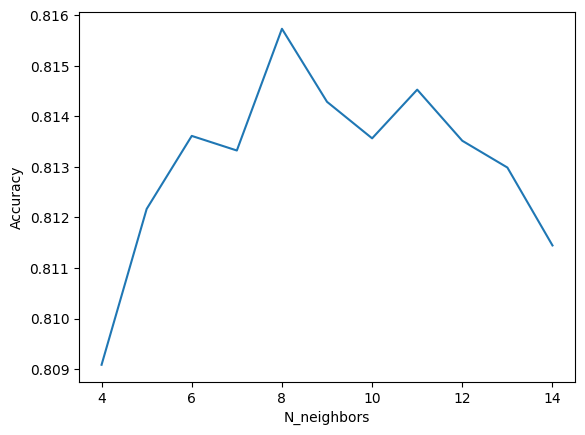

In [98]:
## limit x vars to top 10 by gini importance (determined in rf section)
x_train_ordenc = pd.DataFrame(ct_ord.fit_transform(x_train), columns=ct_ord.get_feature_names_out())
x_test_ordenc = pd.DataFrame(ct_ord.transform(x_test), columns=ct_ord.get_feature_names_out())

## hyperparameter tuning: alpha
param_grid = {'n_neighbors' : np.arange(4,15)}
kf = KFold(n_splits=10, shuffle=True, random_state=8)

knn_tuning = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid, scoring='accuracy', cv=kf)
knn_tuning.fit(x_train_ordenc.values, y_train_le)
knn_tuning_params = knn_tuning.cv_results_['param_n_neighbors']

## find best param with highest accuracy
knn_tuning_params = knn_tuning.cv_results_['param_n_neighbors']
knn_tuning_accr = knn_tuning.cv_results_['mean_test_score']
plt.plot(knn_tuning_params, knn_tuning_accr)
plt.xlabel('N_neighbors')
plt.ylabel('Accuracy')

print('best_params =', knn_tuning.best_params_)
print('best_score =', knn_tuning.best_score_)

In [99]:
## instantiate knn algorithm, using best tuned param
knn = KNeighborsClassifier(n_neighbors=8, weights='distance')

## fit model to training data
knn.fit(x_train_ordenc.values, y_train_le); None

### Stacking

In [53]:
## stack rf, xgbclass using logistic meta estimator
classifiers = [
    ('rf', rf),
    ('xgbclass', xgbclass)
]
stack_rf_xgb = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(max_iter=1000), cv=5, n_jobs=-1, passthrough=True)

## fit model to training data
stack_rf_xgb.fit(x_train_onehot, y_train_le); None

## Test Predictions

In [12]:
## set up submission format - i.e. Id & NObeyesdad
id = np.arange(len(train), len(train)+len(test))
submission = pd.DataFrame(data={'id':id, 'NObeyesdad':''})

In [13]:
## xgb prediction
y_testpred_xgb = xgbclass.predict(x_test_onehot.values)
y_testpred_xgb = le.inverse_transform(y_testpred_xgb)
submission['NObeyesdad'] = y_testpred_xgb
submission.to_csv('Submissions/test_pred_xgb_v3.csv', index=False)

In [52]:
## rf prediction
y_testpred_rf = rf.predict(x_test_onehot.values)
y_testpred_rf = le.inverse_transform(y_testpred_rf)
submission['NObeyesdad'] = y_testpred_rf
submission.to_csv('Submissions/test_pred_rf_v1.csv', index=False)

In [54]:
## stack_rf_xgb prediction
y_testpred_stack_rf_xgb = stack_rf_xgb.predict(x_test_onehot)
y_testpred_stack_rf_xgb = le.inverse_transform(y_testpred_stack_rf_xgb)
submission['NObeyesdad'] = y_testpred_stack_rf_xgb
submission.to_csv('Submissions/test_pred_stack_rf_xgb_v2.csv', index=False)